# Re-fitting literature scaling relations for comparisons

## Import statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
import pickle

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo

import xga
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.relations.fit import scaling_relation_lira

## Setting up parameter normalisations

In [12]:
tx_norm = Quantity(5, 'keV')
mhy_norm = Quantity(4e+14, 'Msun')
lx_norm = Quantity(1e+44, 'erg/s')
rich_norm = Quantity(50)

## Mass-Temperature

### [Arnaud et al. 2005](https://arxiv.org/abs/astro-ph/0502210)

#### Reading in the data

I took this data from Table 1 of the paper.

It is worth noting that the cosmology used for the Arnaud analysis is the same concordance cosmology that we assume for our SDSSRM-XCS analysis. 

Its also important to note that their 'global' temperature measurements are taken in a fairly odd region, between 0.1-0.5$R_{200}$. As we don't have an external measure of $R_{200}$ for the SDSSRM-XCS clusters, we cannot easily replicate this for a comparison to this scaling relation.

In [ ]:
arnaud_data = pd.read_csv('../../sample_files/for_sr_comp/arnaud2005.csv')
arnaud_data

Now we need to put this data into astropy quantities so that its compatible with XGA's scaling relation objects.

In [ ]:
arnaud_ez = xcs_cosmo.efunc(arnaud_data['z'].values)
arnaud_m500 = Quantity(arnaud_data[['m500', 'm500_err']], '10^14Msun').to("Msun")
arnaud_tx = Quantity(arnaud_data[['Tx', 'Tx_err']], 'keV')

#### Fitting the Arnaud $M^{\rm{hy}}_{500}$-$T_{\rm{X}}$ relation with LIRA

In [ ]:
y_name = r'E(z)$M^{\rm{hy}}_{500}$'
x_name = r'$T_{\rm{X}}$'
arnaud_m500_Tx = scaling_relation_lira(arnaud_m500[:, 0]*arnaud_ez, arnaud_m500[:, 1]*arnaud_ez, 
                                       arnaud_tx[:, 0], arnaud_tx[:, 1],  mhy_norm, tx_norm, y_name=y_name, 
                                       x_name=x_name)
arnaud_m500_Tx.name = 'Arnaud et al. 2005'
arnaud_m500_Tx.year = 2005
arnaud_m500_Tx.author = 'Arnaud et al.'
arnaud_m500_Tx.doi = '10.1051/0004-6361:20052856'

In [ ]:
arnaud_m500_Tx.view(figsize=(6.5, 6.5), model_colour='tab:blue')

### [Lovisari et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...892..102L/abstract)

#### Reading in the data

This data was taken from the [VizieR table](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJ/892/102&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa) that accompanied the paper. Multiple measures of temperature and luminosity are available, with and without core excision; I believe that the global kT measurements are taken within $R_{500}$, and the core-excised are within $0.15-1R_{500}$.

In [ ]:
lovisari_data = pd.read_csv('../../sample_files/for_sr_comp/lovisari2020.csv')
lovisari_data.head(5)

Creating astropy quantities to fit scaling relations from. Lowercase 'e' indicates a lower uncertainty, uppercase 'E' indicates an upper uncertainty:

In [ ]:
lovisari_ez = xcs_cosmo.efunc(lovisari_data['z'].values)
lovisari_m500 = Quantity(lovisari_data[['M500', 'e_M500', 'E_M500']], '10^14Msun').to("Msun")
lovisari_tx = Quantity(lovisari_data[['kT', 'e_kT', 'E_kT']], 'keV')

#### Fitting the Lovisari $M^{\rm{hy}}_{500}$-$T_{\rm{X}}$ relation with LIRA

In [ ]:
y_name = r'E(z)$M^{\rm{hy}}_{500}$'
x_name = r'$T_{\rm{X}}$'
lovisari_m500_Tx = scaling_relation_lira(lovisari_m500[:, 0]*lovisari_ez, 
                                         lovisari_m500[:, 1:]*lovisari_ez[..., None], 
                                         lovisari_tx[:, 0], lovisari_tx[:, 1:], mhy_norm, tx_norm, y_name=y_name, 
                                         x_name=x_name)
lovisari_m500_Tx.name = 'Lovisari et al. 2020'
arnaud_m500_Tx.year = 2020
arnaud_m500_Tx.author = 'Lovisari et al.'
arnaud_m500_Tx.doi = '10.3847/1538-4357/ab7997'

In [ ]:
lovisari_m500_Tx.view(figsize=(6.5, 6.5), model_colour='darkgreen')

### Contours of both comparison relations

In [ ]:
(lovisari_m500_Tx+arnaud_m500_Tx).view_corner(contour_colours=['darkgreen', 'tab:blue'])

## Mass-Luminosity

### [Lovisari et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...892..102L/abstract)

Luminosities are measured both within a 0.1-2.4keV band, and a 0.01-100keV (bolometric) band. There are also measurements within $R_{500}$, and within $0.15-1R_{500}$ (core-excised).

#### Defining astropy quantities for fitting

In [ ]:
lovisari_lx = Quantity(lovisari_data[['LX', 'e_LX', 'E_LX']]*1e+44, 'erg/s')
lovisari_lxce = Quantity(lovisari_data[['LXexc', 'e_LXexc', 'E_LXexc']]*1e+44, 'erg/s')

lovisari_lxbol = Quantity(lovisari_data[['Lbol', 'e_Lbol', 'E_Lbol']]*1e+44, 'erg/s')
lovisari_lxbolce = Quantity(lovisari_data[['Lbolexc', 'e_Lbolexc', 'E_Lbolexc']]*1e+44, 'erg/s')

#### Fitting the Lovisari $M^{\rm{hy}}_{500}$-$L^{0.1-2.4\rm{keV}}_{\rm{X, 500}}$ relation with LIRA

In [ ]:
y_name = r'E(z)$M^{\rm{hy}}_{500}$'
x_name = r'$L^{0.1-2.4\rm{keV}}_{\rm{X, 500}}$'
lovisari_m500_Lx = scaling_relation_lira(lovisari_m500[:, 0]*lovisari_ez, 
                                         lovisari_m500[:, 1:]*lovisari_ez[..., None], 
                                           lovisari_lx[:, 0], lovisari_lx[:, 1:], mhy_norm, lx_norm, 
                                           y_name=y_name, x_name=x_name)
lovisari_m500_Lx.name = 'Lovisari et al. 2020'

In [ ]:
lovisari_m500_Lx.view(figsize=(6.5, 6.5), model_colour='teal')

#### Fitting the Lovisari $M^{\rm{hy}}_{500}$-$L^{0.1-2.4\rm{keV}}_{\rm{X, 500ce}}$ relation with LIRA

In [ ]:
y_name = r'E(z)$M^{\rm{hy}}_{500}$'
x_name = r'$L^{0.1-2.4\rm{keV}}_{\rm{X, 500ce}}$'
lovisari_m500_Lxce = scaling_relation_lira(lovisari_m500[:, 0]*lovisari_ez, 
                                           lovisari_m500[:, 1:]*lovisari_ez[..., None], 
                                           lovisari_lxce[:, 0], lovisari_lxce[:, 1:], mhy_norm, lx_norm, 
                                           y_name=y_name, x_name=x_name)
lovisari_m500_Lxce.name = 'Lovisari et al. 2020'

In [ ]:
lovisari_m500_Lxce.view(figsize=(6.5, 6.5), model_colour='lightsteelblue')

#### Fitting the Lovisari $M^{\rm{hy}}_{500}$-$L^{\rm{bol}}_{\rm{X, 500}}$ relation with LIRA

In [ ]:
y_name = r'E(z)$M^{\rm{hy}}_{500}$'
x_name = r'$L^{0.1-2.4\rm{keV}}_{\rm{X, 500}}$'
lovisari_m500_Lbol = scaling_relation_lira(lovisari_m500[:, 0]*lovisari_ez, 
                                           lovisari_m500[:, 1:]*lovisari_ez[..., None], 
                                           lovisari_lxbol[:, 0], lovisari_lxbol[:, 1:], mhy_norm, lx_norm, 
                                           y_name=y_name, x_name=x_name)
lovisari_m500_Lbol.name = 'Lovisari et al. 2020'

In [ ]:
lovisari_m500_Lbol.view(figsize=(6.5, 6.5), model_colour='olive')

#### Fitting the Lovisari $M^{\rm{hy}}_{500}$-$L^{\rm{bol}}_{\rm{X, 500ce}}$ relation with LIRA

In [ ]:
y_name = r'E(z)$M^{\rm{hy}}_{500}$'
x_name = r'$L^{0.1-2.4\rm{keV}}_{\rm{X, 500ce}}$'
lovisari_m500_Lbolce = scaling_relation_lira(lovisari_m500[:, 0]*lovisari_ez, 
                                             lovisari_m500[:, 1:]*lovisari_ez[..., None], 
                                             lovisari_lxbolce[:, 0], lovisari_lxbolce[:, 1:], mhy_norm, lx_norm, 
                                             y_name=y_name, x_name=x_name)
lovisari_m500_Lbolce.name = 'Lovisari et al. 2020'

In [ ]:
lovisari_m500_Lbolce.view(figsize=(6.5, 6.5), model_colour='seagreen')

###  Contours of the Mass-Luminosity comparison relations

In [ ]:
comb_MLx_colours = ['teal', 'lightsteelblue', 'olive', 'seagreen'] 
comb_MLx = (lovisari_m500_Lx+lovisari_m500_Lxce+lovisari_m500_Lbol+lovisari_m500_Lbolce)
comb_MLx.view_corner(contour_colours=comb_MLx_colours)

## Mass-Richness

### [Andreon et al. 2014](https://www.aanda.org/articles/aa/full_html/2014/08/aa23616-14/aa23616-14.html)

#### Reading in the data

Table 1

In [3]:
andreon_data = pd.read_csv('../../sample_files/for_sr_comp/andreon2014.csv')
andreon_data.head(5)

,Name,z,log10n0.5,log10n0.5_err,log10M0.5,log10M0.5_err
0,Abell2104,0.15,1.44,0.08,14.53,0.06
1,Abell1914,0.17,1.72,0.06,14.54,0.05
2,MS0440.5+0204,0.19,1.29,0.09,14.40,0.09
3,Abell520,0.20,1.42,0.08,14.53,0.06
4,Abell2163,0.20,1.49,0.07,14.62,0.06


Again need to put these values into astropy quantities. This requires a little massaging due to the format of the data stored in the table.

In [4]:
andreon_ez = xcs_cosmo.efunc(andreon_data['z'].values)

# Has to be done this way because the errors presented in the paper are logged
andreon_m_vals = 10**andreon_data['log10M0.5']
andreon_m_errs = andreon_data['log10M0.5_err']*np.log(10)*andreon_m_vals
andreon_m = Quantity([andreon_m_vals, andreon_m_errs], 'Msun').T

andreon_rich = Quantity(10**andreon_data[['log10n0.5', 'log10n0.5_err']], '')
andreon_rich_vals = 10**andreon_data['log10n0.5']
andreon_rich_errs = andreon_data['log10n0.5_err']*np.log(10)*andreon_rich_vals
andreon_rich = Quantity([andreon_rich_vals, andreon_rich_errs], '').T

#### Fitting an Andreon $M^{\rm{}}_{0.5\rm{Mpc}}$-$\lambda$ relation with LIRA

In [13]:
y_name = r'E(z)$M^{\rm{WL}}_{0.5\rm{Mpc}}$'
x_name = r'$\lambda_{0.5\rm{Mpc}}$'
andreon_m_rich = scaling_relation_lira(andreon_m[:, 0]*andreon_ez, andreon_m[:, 1]*andreon_ez, andreon_rich[:, 0], 
                                       andreon_rich[:, 1],  mhy_norm, rich_norm, y_name=y_name, x_name=x_name)
andreon_m_rich.name = 'Andreon et al. 2014'
andreon_m_rich.year = 2014
andreon_m_rich.author = 'Andreon et al.'
andreon_m_rich.doi = '10.1051/0004-6361/201423616'

  |**************************************************| 100%


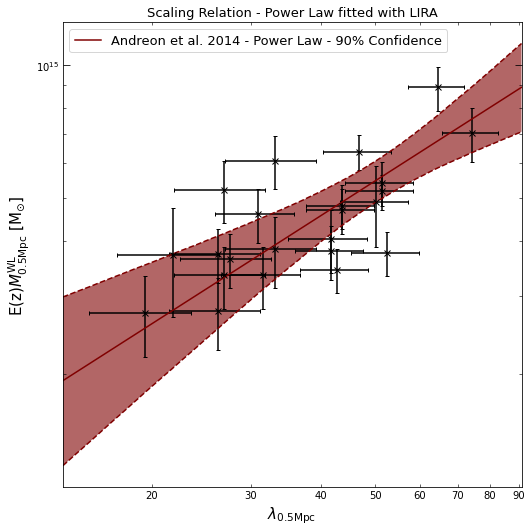

In [14]:
andreon_m_rich.view(figsize=(7.5, 7.5), model_colour='maroon')

Removed no burn in


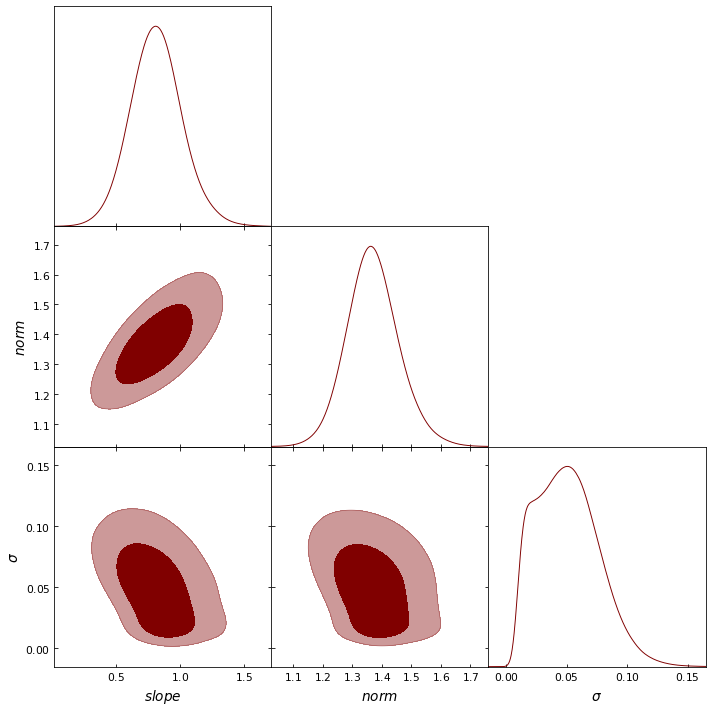

In [15]:
andreon_m_rich.view_corner(colour='maroon')